# Compute the annual temperature anomaly from Temperature12k

This notebooks computes GMST using Generalized Additive Models (GAM). 

The main output is a netCDF file `annual-with-single-seas-gam-band-means.nc` with the temperature anomaly with reference to the 5000-3000 year BP period for the six latitudinal bands -90 to -60, -60 to -30, -30 to 0, 0 to 30, 30 to 60 and 60 to 90 degrees North.

This notebook is divided into four sections.

1. [Read the LiPD files](#lipds)
2. [Transform them into a combined dataframe](#pandas)
3. [Compute the grid cell anomalies](#cell-anomalies)
4. [Compute the band means](#band-anomalies)

Note that you have to set the [version for the database](#db_version) manually.

In [1]:
import pandas as pd
import numpy as np
import os.path as osp
import os
from urllib import request
import zipfile
import pickle
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import warnings
import xarray as xr
import multiprocessing as mp
import psyplot.data as psyd
import gam_ensemble as ge
import pyleogrid as pg
from distributed import Client
import psyplot.project as psy
from dask_jobqueue import SLURMCluster
from matplotlib.animation import FuncAnimation
import contextlib
from sklearn.neighbors import BallTree
from latlon_utils import get_climate
import lipd

## Read the LiPD files <a name="lipds"></a>
In this section we read the temperature from the LiPD files. This involves some [filtering](#filter) to only keep the necessary temperature series. Note however, that samples with NaN are filtered [down below](#filter-nan).

<a id=db_version></a>Read in the LipD data from http://lipdverse.org/globalHolocene/current_version

You should set the latest version here manually!

In [2]:
%matplotlib inline

In [3]:
db_version = '1_0_0'

In [4]:
lipd_dir = f'../lipds_{db_version}'

Download the LiPD file if the input directory does not yet exist

In [5]:
%%time
if not osp.exists(lipd_dir):
    os.makedirs(lipd_dir)
    zipped = f'Temp12k_v{db_version}_LiPD.zip'
    uri = f'https://www1.ncdc.noaa.gov/pub/data/paleo/reconstructions/climate12k/temperature/version{db_version.replace("_", ".")}/{zipped}'
    target = osp.join(lipd_dir, zipped)
    print('downloading ' + uri)
    request.urlretrieve(uri, target)
    with zipfile.ZipFile(target) as f:
        f.extractall(lipd_dir)

CPU times: user 0 ns, sys: 336 µs, total: 336 µs
Wall time: 1.12 ms


In [6]:
@contextlib.contextmanager
def remember_cwd():
    """Context manager to switch back to the current working directory

    Usage::

        with remember_cwd():
            os.chdir('test')
            print(os.getcwd())  # test
        print(os.getcwd())      # test/.."""
    curdir = os.getcwd()
    try:
        yield
    except:
        raise
    finally:
        os.chdir(curdir)

Load the data from the LiPD files it is has not yet been serialized as a pickled object.

In [7]:
%%time
pickle_file = f'{lipd_dir}/lipds.pkl'
if osp.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
else:
    with remember_cwd():
        os.chdir(f'{lipd_dir}/')
        data = lipd.readLipd('.')
    with open(pickle_file, 'wb') as f:
        pickle.dump(data, f)

CPU times: user 217 ms, sys: 85.4 ms, total: 302 ms
Wall time: 325 ms


Extract the individual time-series from the LiPD files

In [8]:
%%time
all_series = lipd.extractTs(data)

extracting paleoData...
extracting: GodziszewskieLake.Miotk.1986
extracting: Hudson.Clegg.2011
extracting: ParkPond1.Lynch.1998
extracting: ElGygytgynCrater.Schwamborn.2006
extracting: Dalmutladdo.Bjune.2004
extracting: GeoB10043_3.Setiawan.2015
extracting: MD99_2341.Eynaud.2009
extracting: CN01.Cheung.2017
extracting: HumberPond5.McAndrews.1989
extracting: TauldintreBrazi.Toth.2015
extracting: LagunaSaladaChiprana.EPD
extracting: PrazRodet.Shotyk.1997
extracting: SaladaPequena.EPD
extracting: Leviathan.Lachniet.2014
extracting: BloodPond.Marsicek.2013
extracting: Khatanga-12Lake.Syrykh.2017
extracting: rainbow.Clegg.2011
extracting: M77_2_024_5.Salvatteci.2019
extracting: GeoB7926_2.Kim.2012
extracting: LagoMoreno.Markgraf.2002
extracting: PolandSpring.Jacobson.Ja
extracting: MSM05-712.Muller.2013
extracting: Gammelheimvatnet.Seppa.2009
extracting: WCA3BGumboLimboMarsh.Willard.2001
extracting: NussbaumerSeen.Rsch.1995
extracting: DevonIslandGlacier.McAndrews.1984
extracting: klotjarne

extracting: M77_2_029_3.Salvatteci.2019
extracting: MSM05_5_712_2.Werner.2013
extracting: brurskardstjorni.Velle.2005
extracting: BattleGround.Whitlock.1985
extracting: Sokli.Shala.2017
extracting: LiivjarveBog.Koff.1989
extracting: GeoB4905_4.Weldeab.2005
extracting: Zabieniec.Plociennik.2011
extracting: Stazersee.Heiri.2015
extracting: D13882.Tierney
extracting: Frozen.Rosenberg.2004
extracting: PupukeChironomid.VandenBos.2018
extracting: GYXO.Self.2015
extracting: BebrukasLake.Shulija.1967
extracting: MD03_2699.Rodrigues.2010
extracting: LittleLochRoag.Birks.1979
extracting: Haugtjern.Eide.2009
extracting: PC_1.Chang.2015
extracting: EDML.Stenni.2010
extracting: PlateauRemote.MosleyThompson.1996
extracting: B997_324.Castaneda.2004
extracting: M77_2_003_2.Salvatteci.2019
extracting: KNR195_5_CDH23.Bova.2015
extracting: MD79_257.Bard.1997
extracting: Decoy.Szeicz.1991
extracting: MD95_2011.Risebrobakken.2003
extracting: Ennadai-2.Nichols.1975
extracting: Gemini.Samartin.2017
extractin

extracting: MD02_2503.Hill.2006
extracting: VuolepNjakajaure.Heinrichs.2006
extracting: GeoB9310_4.Weldeab.2014
extracting: ODP_167_1019C.Barron.2003
extracting: JR01.Fortin.2017
extracting: Hams.Bennett.1987
extracting: Ostrowite.Milecka.2002
extracting: StaroselskyMoch.Novenko.2018
extracting: Churruca.Caniupan.2014
extracting: Sluggan.Smith.1991
extracting: Luganskoe.Kvavadze.1994
extracting: RedRock.Maher.1972
extracting: MD06_3075.Fraser.2014
extracting: LagoDellAccesa.Finsinger.2010
extracting: Hinterburgsee.Heiri.2015
extracting: Dalene.Seppa.2009
extracting: Eldora.Maher.1969
extracting: PointEscuminac.Warner.1991
extracting: TR163_31.Dubois.2009
extracting: SV04.Rigual-Hernndez.2017
extracting: EN32_PC6.Flower.2004
extracting: Delorme1.Bouchard.1982
extracting: RR1313_23PC.MoffaSanchez.2019
extracting: DolgoeLake.Wolfe.2000
extracting: Spannagel.Fohlmeister.2012
extracting: MountHoney.McGlone.2010
extracting: GeoB1711_4.Kirst.1999
extracting: MD95_2043.Cacho.1999
extracting: H

Filter all the series to extract the calibrated temperature series <a name="filter"></a>

In [9]:
filtered_ts_temp12k = lipd.filterTs(all_series,'paleoData_inCompilation == Temp12k')
temperatures = lipd.filterTs(filtered_ts_temp12k,'paleoData_units == degC')

Found 1319 matches from 5088 columns
Found 1276 matches from 1319 columns


## Conversion to pandas
Now that we have the time-series, we transform them to a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). This allows us to use groupby and other database measures.

For this purpose, we first define a few meta data attributes that should be kept for every record.

- `meta_cols` is the attribute in the dictionary of the individual time series. If the attribute is within a key or list, you can separate them by a single `.`. 
  
  `paleoData_interpretation.0.seasonalityGeneral` 
  
  for instance will be interpreted as
  
  `d['paleoData_interpretation'][0]['seasonalityGeneral']`
- `meta_names` is the name of the corresponding attribute in `meta_cols` how it should be saved in the dataframe

In [10]:
meta_cols = ['geo_meanLon', 'geo_meanLat', 'dataSetName', 'paleoData_variableName', 'paleoData_TSid', 
             'paleoData_interpretation.0.seasonalityGeneral', 'paleoData_datum', 'paleoData_proxy']
meta_names = ['lon', 'lat', 'dataSetName', 'variableName', 'TSid', 'seasonality', 'datum', 'proxy']

Then every dictionary in `temperatures` is converted to a pandas datafram

In [11]:
frames = []
failures = []
for d in pg.utils.log_progress(temperatures):
    if 'age' in d:
        try:
            s = pd.Series(
                np.asarray(d['paleoData_values'], dtype=float),
                index=pd.Index(np.asarray(d['age'], dtype=float), name='age'),
                name='temperature')
        except ValueError:
            failures.append(d)
        else:
            # keep NaN of ages, these are filtered out later
            s = s[(~np.isnan(s.index)) & (s.index > -70 ) & (s.index < 14000)]
            # if the time series has (in average) more than one sample per
            # decade, we use decadal averages
            if s.size > 1470:
                s = s.groupby(lambda i: 5 + i - (i % 10)).mean()
                s.index.name = 'age'
            s.index.name = 'age'
            frame = s.to_frame().reset_index()
            for i, name in enumerate(meta_cols):
                sub = d
                vals = name.split('.')
                name = vals[-1]
                for v in vals[:-1]:
                    sub = sub[v if isinstance(sub, dict) else int(v)]
                frame[meta_names[i]] = sub.get(name, np.nan)
            frames.append(frame)
print(f"Failed to read {len(failures)} time series")

Starting at 2020-04-16 20:34:35.022730
|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 0.000 minutes
Finished at 2020-04-16 20:34:41.639434. Time needed: 0.110 minutes
Failed to read 0 time series


Now we concatenate everything into one large dataframe

In [12]:
df = pd.concat(frames, ignore_index=True)
df.head()

,age,temperature,lon,lat,dataSetName,variableName,TSid,seasonality,datum,proxy
0,212.13,-2.045714,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,abs,pollen
1,275.05,-4.110000,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,abs,pollen
2,337.83,-3.375714,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,abs,pollen
3,427.04,-2.907143,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,abs,pollen
4,515.32,-4.094286,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,abs,pollen


### Estimation of uncertainties

The age uncertainty is estimated such, that it is 50 years at 0 BP and 250 years at 12k BP

In [13]:
df['age_unc'] = 50 + df.age * (250 - 50) / 12000

The temperature uncertainty is estimated per proxy and per season <a name="temp-unc"></a>

In [14]:
uncertainties = pd.read_excel(
    '../data/proxy-uncertainties.xlsx', sheet_name='Summary', 
    index_col='proxy', usecols=[0, 1, 2, 3])
uncertainties

,summer,winter,annual
proxy,,,
pollen,2.017837,3.012946,2.105745
other microfossils/dinocyst,1.700000,1.200000,1.200000
chironomid,1.399705,NaN,NaN
other microfossils/diatoms,1.122375,NaN,NaN
other microfossils/radiolaria,1.200000,NaN,NaN
other microfossils/foraminifera,1.325000,1.412500,1.282500
alkenone,NaN,NaN,1.650000
MgCa,1.850000,1.850000,1.850000
GDGT (MBT/CBT as well as BrGDGT fractional abundance),NaN,NaN,2.902857


In [15]:
uncertainty_map = {
    'dinocyst': 'other microfossils/dinocyst',
    'pollen': 'pollen', 
    'chironomid': 'chironomid',
    'alkenone': 'alkenone',
    'GDGT': 'GDGT (MBT/CBT as well as BrGDGT fractional abundance)',
    'Mg/Ca': 'MgCa',
    'macrofossils': 'macrofossils',
    'bubble frequency': 'bubble frequency',
    'borehole': 'borehole',
    'C15 fatty alcohols': 'C15 fatty alcohols',
    'd18O': 'd18O',
    'radiolaria': 'other microfossils/radiolaria',
    'foraminifera': 'other microfossils/foraminifera',
    'dD': 'dD',
    'd13C': 'd13C',
    'diatom': 'other microfossils/diatoms',
    'isotope diffusion': 'isotope diffusion',
    'TRW': 'TRW',
    'hybrid-ice': 'hybrid-ice',
    'deterium excess': 'deterium excess',
    'gas': 'gas',
    'chlorophyll': 'chlorophyll',
    'melt layer': 'melt layer',
    '3-OH-Fatty Acids': '3-OH-Fatty Acids',
    'TEX86': 'GDGT (Tex86)',
    'LDI': 'LDI',
    'long chain diol': 'long chain diol'
}
uncertainty_map_inv = {val: key for key, val in uncertainty_map.items()}

In [16]:
df['seas'] = np.nan
seasonality = df.seasonality.fillna('')
df.loc[seasonality.str.startswith('summer'), 'seas'] = 'summer'
df.loc[seasonality.str.startswith('winter'), 'seas'] = 'winter'
df.loc[seasonality.str.startswith('annual'), 'seas'] = 'annual'

In [17]:
last = uncertainties.isnull().all(axis=1)
uncertainties = uncertainties.iloc[:np.argmax(last.values)]
# default uncertainty: 75th percentile of all values without d18O
df['temp_unc'] = 1.975877719
for proxy, row in uncertainties.iterrows():
    for seas, val in row[row.notnull().values].items():
        mask = (df.proxy == uncertainty_map_inv[proxy]) & (df.seas == seas)
        df.loc[mask.values, 'temp_unc'] = val

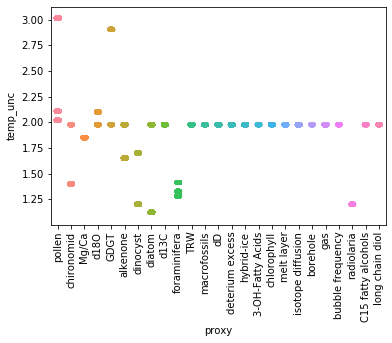

In [18]:
import seaborn as sns
ax = sns.stripplot('proxy', 'temp_unc', data=df)
for t in ax.get_xticklabels():
    t.set_rotation(90)

Now we filter out samples that have unrealistic temperatures, or no seasonality <a name="filter-nan"></a>.

In [19]:
df.loc[~df.temperature.between(-200, 200).values, 'temperature'] = np.nan

In [20]:
for col in ['seasonality', 'temperature']:
    print(f'NaN for {col}: {df[col].isnull().sum()}')

NaN for seasonality: 0
NaN for temperature: 10641


In [21]:
print(df.shape)
df.dropna(subset=['seasonality', 'temperature'], inplace=True)
print(df.shape)

(121457, 13)
(110816, 13)


## Computation of the grid cell anomalies <a name="cell-anomalies"></a>

Now that the input data is filtered and ready to use, we compute the anomalies per grid cell. For this purpose, we use the `GAMEnsemble` class defined in [gam_ensemble.py](gam_ensemble.py).

We use all annual records, and, if there is only a summer or winter record available in the LiPD dataset, we use this one as well.

In [22]:
with psyd.open_dataset('../data/equal-area-grid-N4000.nc') as _ds:
    output_ds = _ds.load()
area = output_ds['cell_area']
output_ds['time'] = time = xr.Variable(
    ('time', ), np.arange(12050, -100, -100),
    attrs = {'long_name': 'Age', 'units': 'years since 1950-01-01'})
output_ds['temperature'] = xr.Variable(
    ('time', area.dims[0]), np.full((time.size, area.size), np.nan),
    encoding = dict(coordinates='clat clon'))

ensemble = ge.GAMEnsemble(
    df[(df.seasonality == 'annual') | 
       (df.seasonality == 'summerOnly') | 
       (df.seasonality == 'winterOnly')].set_index('age'), 
    target=output_ds.psy['temperature'],
    climate='temperature', ds_id='TSid')

### Generate the ensemble
For age, we use a gibbs sampling algorithm to generate an ensemble of 500 ages per sample. For temperature, we use a normal distribution defined by the temperature of the sample and the uncertainty [estimated above](#temp-unc).

In [23]:
%%time
ds = ensemble.input_data
ages = ensemble.sample_ages(size=500, use_dask=False)
ds['age_ensemble'] = ages.load()
ds['temperature_ensemble'] = ages.rename('temperature_ensemble').copy(
    data=np.random.normal(ds.temperature, ds.temp_unc,
                          size=ages.shape))

CPU times: user 47 s, sys: 959 ms, total: 48 s
Wall time: 48 s


We save the input data to share it with others

In [24]:
output_dir = f'../output_{db_version}'
!mkdir -p {output_dir}

In [25]:
to_keep = [
    'dataSetName',
    'variableName',
    'seasonality',
    'datum',
    'proxy',
    'age_unc',
    'seas',
    'temp_unc',
    'age_ensemble',
    'temperature_ensemble'
]

key = 'annual-with-single-seas'

ds = ensemble.input_data[to_keep]
encoding = {v: dict(zlib=True, complevel=4)
            for v in ds.variables}
for var in ds.variables:
    if np.issubdtype(ds[var].dtype, np.number):
        encoding[var]['least_significant_digit'] = 5
ofile = f'{output_dir}/{key}_input.nc'
ds.rename_dims(age='sampleId').to_netcdf(
    ofile, encoding=encoding)

### Computation of grid cell anomalies
The heavy part comes now, we compute the grid cell anomalies and save them to `annual-with-single-seas-gam-ref-5000-3000-bp.nc`.

In [26]:
n_workers = 64

cluster = SLURMCluster(cores=1, dashboard_address=":33913", walltime="03:00:00")
cluster.scale(n_workers)

try:
    with Client(cluster) as client:
        with warnings.catch_warnings() as c:
            warnings.filterwarnings('ignore', '\s*indexing past lexsort depth')
            output = ensemble.predict(
                size=500, client=client, use_gam=True, return_counts=100, max_time_diff=14000,
                modern_young=3000, modern_old=5000)
            output['time'].values *= -1
            output.to_netcdf(f'{output_dir}/{key}-gam-ref-5000-3000-bp.nc')
finally:
    cluster.close()

Starting at 2020-04-16 20:36:02.349596
|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 0.042 minutes
Finished at 2020-04-16 20:49:38.567308. Time needed: 13.604 minutes


We only want to use the gam prediction if

- there has been more than 100 samples between 5k and 3k BP in the ensemble
- there were at least 100 samples in the surrounding 300 years of the time of prediction

In [27]:
# valid = output.nsamples.sel(time=slice(-5000, -3000)).sum(dim='time')
valid = output.nsamples.where((output.time > -5000) & (output.time < -3000), drop=True).sum(dim='time')
surrounding = output.nsamples.rolling(time=3).sum()

In [28]:
output = output.where(valid > 100)
output = output.where(surrounding > 100)

## Computation of latitudinal bands
In the last part of this analysis we compute the mean of the individual latitudinal bands. We are using an equal-area grid here, as such, we do not have to worry about the latitudinal weighting.

In [29]:
bands = []
with warnings.catch_warnings() as c:
    warnings.filterwarnings('ignore', '\s*Mean of empty slice')
    for lat in pg.utils.log_progress(np.arange(-90, 90, 30)):
        idx = np.where(output.clat - (output.clat % 30) == lat)[0]
        sel = output.isel(cell=idx)
        band = sel.mean('cell')
        
        # compute the sum for the number of samples and the cell_area
        band['nsamples'] = sel.nsamples.sum('cell')
        band['cell_area'] = sel.cell_area.sum('cell')
        band['lat'] = ((), lat + 15)
        bands.append(band)
bands = xr.concat(bands, dim='lat')

Starting at 2020-04-16 20:50:18.926877
|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 0.024 minutes
Finished at 2020-04-16 20:50:26.772733. Time needed: 0.131 minutes


Compute the standard deviation from the ensemble

In [30]:
bands['temperature_std'] = bands.temperature_samples.std('ens')

/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Plot the anomalies of the individual bands

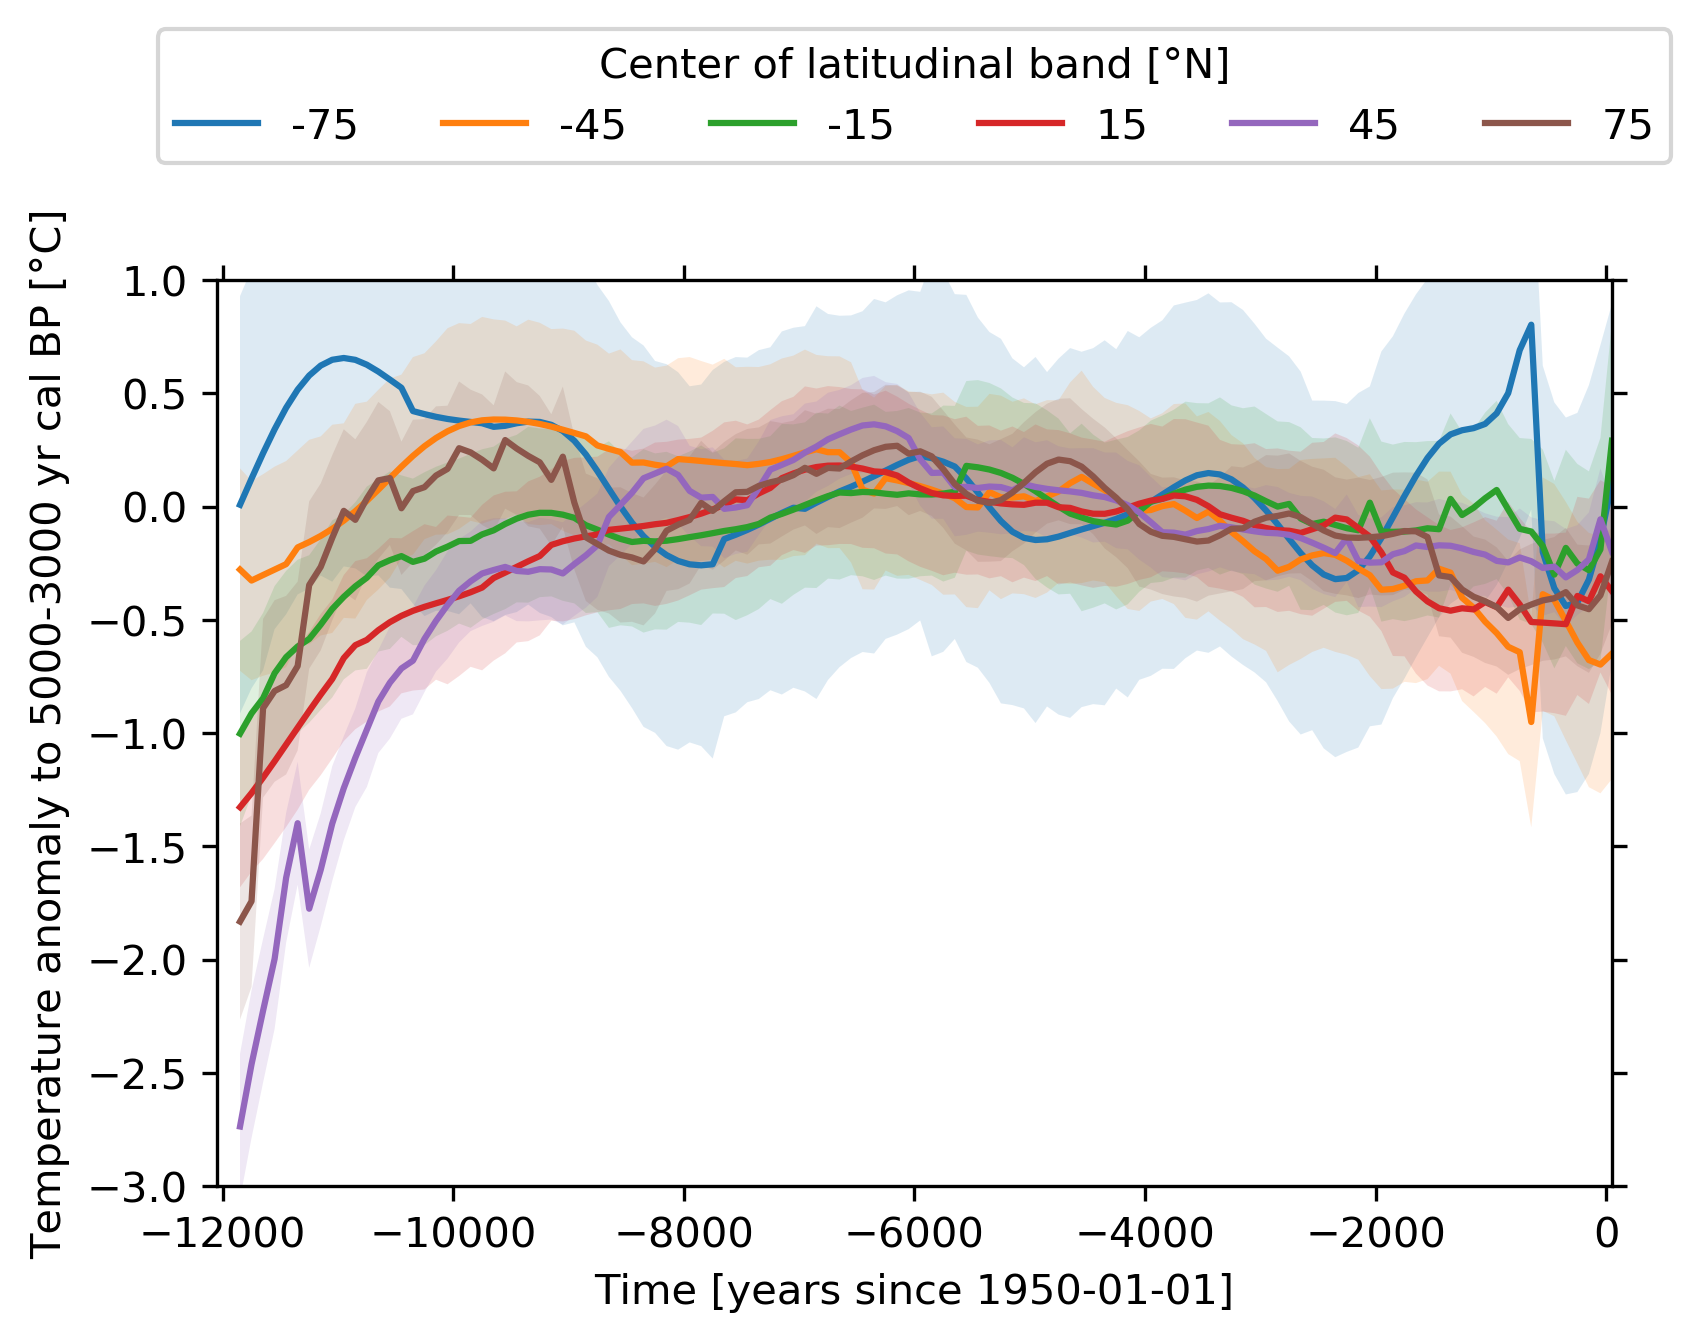

In [31]:
sp = bands.psy.plot.lineplot(
    name=[[['temperature', 'temperature_std']]],
    lat=list(range(6)), legendlabels='%(lat)s',
    xlabel='Time [years since 1950-01-01]',
    ylabel='Temperature anomaly to 5000-3000 yr cal BP [°C]',
    xlim='minmax', 
    legend=dict(loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.3),
                title='Center of latitudinal band [°N]'))

plt.gcf().set_dpi(300)

Compute the samples per band that have been used. There is an nsamples variable already in the file, but this one is based on the entire ensemble.

In [32]:
nsamples = ensemble.input_data.age.groupby_bins('lat', range(-90, 91, 30)).apply(
    lambda da: da.groupby_bins(da, np.arange(0, 12001, 100)).apply(
        lambda da: xr.DataArray(np.unique(da.TSid).size)))
nsamples['lat_bins'] = ('lat_bins', [i.mid for i in nsamples.lat_bins.values])
nsamples['age_bins'] = ('age_bins', [i.mid for i in nsamples.age_bins.values])

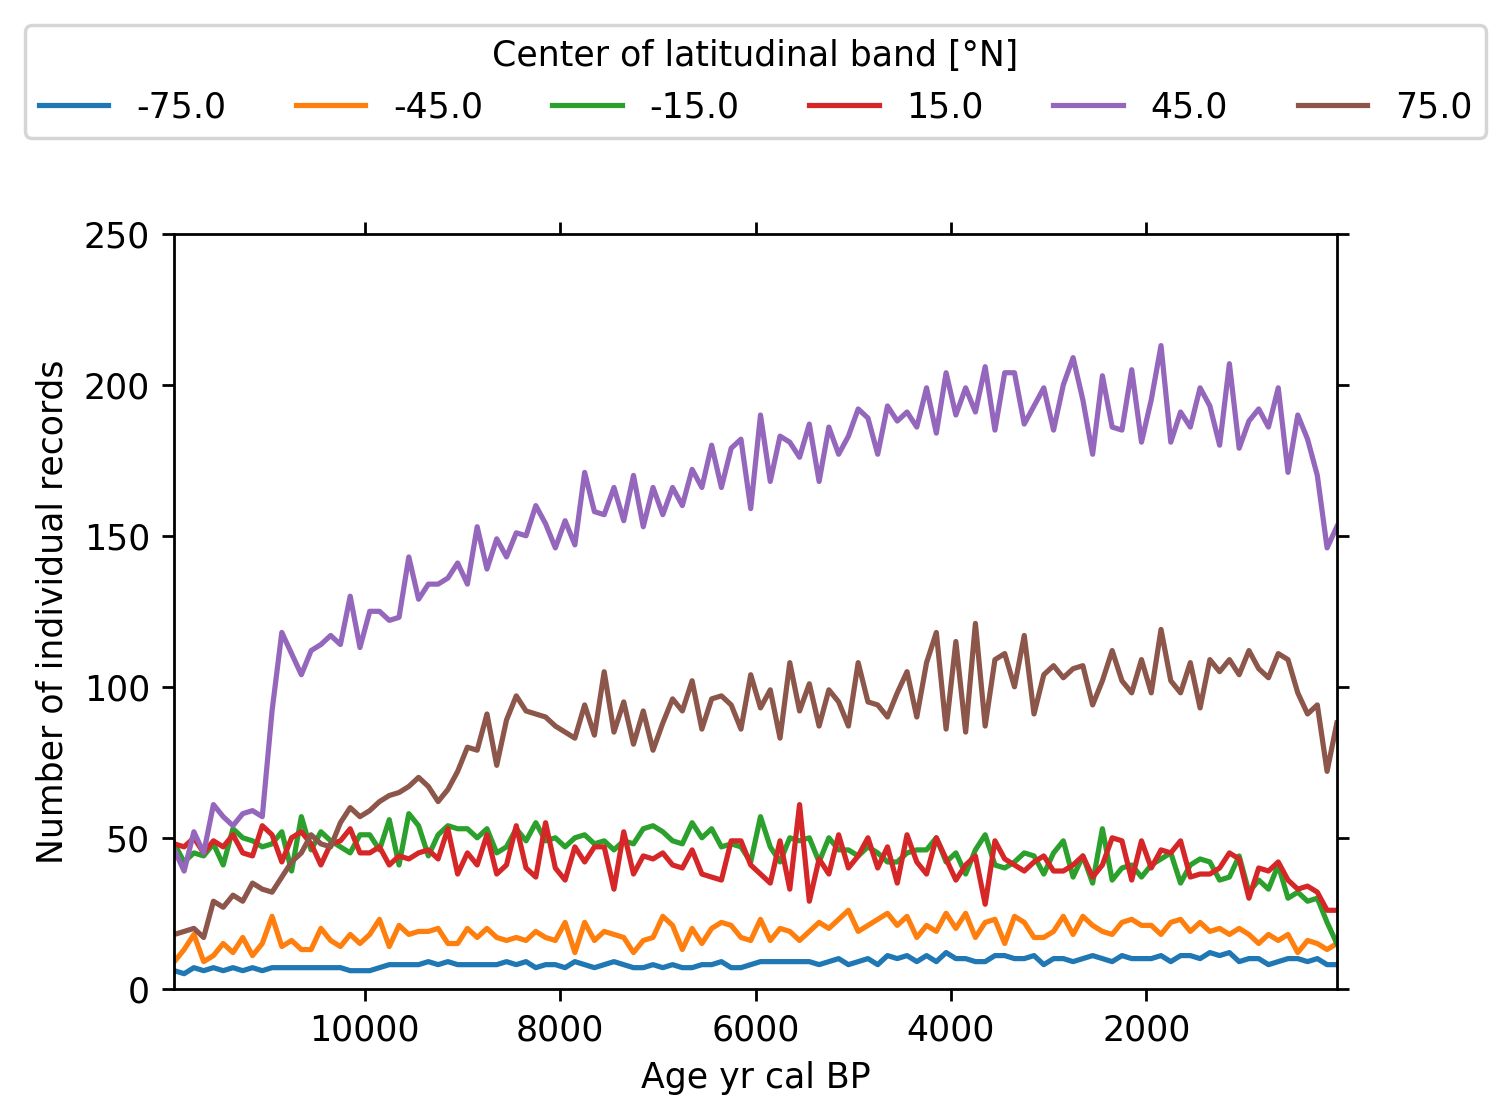

In [33]:
nsamples.to_dataset(name='nsamples').psy.plot.lineplot(
    lat_bins=list(range(6)), legendlabels='%(lat_bins)s',
    ylabel='Number of individual records', xlabel='Age yr cal BP',
    xlim='minmax', 
    legend=dict(loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.3),
                    title='Center of latitudinal band [°N]'))
plt.gcf().set_dpi(250)
plt.gca().invert_xaxis()

In [34]:
bands = bands.rename({'nsamples': 'nsamples_ens'})
bands['nsamples'] = nsamples.rename({'lat_bins': 'lat', 'age_bins': 'age'})

In [35]:
bands.to_netcdf(f'{output_dir}/annual-with-single-seas-gam-band-means.nc',
                encoding={var: {'complevel': 4, 'zlib': True} 
                          for var in bands.variables})